In [1]:
import numpy as np
import pandas as pd
import pylab as plt

import seaborn as sns
import pickle

import warnings

warnings.filterwarnings('ignore')

from prophet import Prophet
from prophet import diagnostics
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

## Load Data

In [2]:
cons_df = pd.read_csv('./../../datasets/prod-region.csv', sep=';')

In [3]:
#reduce information
cons_df.drop(['Région', 'Code région', 'Plage de puissance injection', 'Filière de production', 'Nb points injection',
         'Total énergie injectée (Wh)', 'Courbe Moyenne n°1 (Wh)', 'Indice représentativité Courbe n°1 (%)',
         'Courbe Moyenne n°2 (Wh)', 'Indice représentativité Courbe n°2 (%)',
         'Indice représentativité Courbe n°1 + n°2 (%)', 'Jour max du mois (0/1)', 'Semaine max du mois (0/1)'],
        axis='columns', inplace=True)
cons_df.dropna(inplace=True)
cons_df['Horodate'] = pd.to_datetime(cons_df['Horodate'].values, utc=True)
cons_df['Horodate'] = cons_df['Horodate'].dt.tz_localize(None)
cons_df = cons_df.loc[cons_df['Horodate'] > '2020-06-01']
cons_df = cons_df.groupby('Horodate').sum().iloc[::-1]
cons_df = cons_df.reset_index()
cons_df.head(100)

Horodate  Courbe Moyenne n°1 + n°2 (Wh)
0  2021-12-31 22:30:00                            0.0
1  2021-12-31 22:00:00                            0.0
2  2021-12-31 21:30:00                            0.0
3  2021-12-31 21:00:00                            1.0
4  2021-12-31 20:30:00                            0.0
..                 ...                            ...
95 2021-12-29 23:00:00                            0.0
96 2021-12-29 22:30:00                            0.0
97 2021-12-29 22:00:00                            0.0
98 2021-12-29 21:30:00                            0.0
99 2021-12-29 21:00:00                            0.0

[100 rows x 2 columns]

In [4]:
#area graph (Date Vs Price)
import plotly.express as px
px.scatter(cons_df,
           x='Horodate',
           y='Courbe Moyenne n°1 + n°2 (Wh)')

## Simple Prophet Model

### Acquire and clean data

In [5]:
# Rename columns to fit the Prophet format
data = cons_df.rename(columns={'Horodate':'ds', 'Courbe Moyenne n°1 + n°2 (Wh)':'y'})
#data.to_csv('data.csv')

# Standardize the data
colx = ['y']

data_st = (data[colx] - data[colx].mean()) / data[colx].std()
#data_st = data
data_st['ds'] = data['ds']
data_st['cap'] = data_st['y'].max()*1.2
data_st['floor'] = data_st['y'].min()*1.1
#data_st.to_csv('data_st.csv')

In [6]:
data_st

y                  ds       cap     floor
0     -0.677595 2021-12-31 22:30:00  3.850619 -0.745355
1     -0.677595 2021-12-31 22:00:00  3.850619 -0.745355
2     -0.677595 2021-12-31 21:30:00  3.850619 -0.745355
3     -0.677595 2021-12-31 21:00:00  3.850619 -0.745355
4     -0.677595 2021-12-31 20:30:00  3.850619 -0.745355
...         ...                 ...       ...       ...
27767 -0.677595 2020-06-01 02:30:00  3.850619 -0.745355
27768 -0.677595 2020-06-01 02:00:00  3.850619 -0.745355
27769 -0.677595 2020-06-01 01:30:00  3.850619 -0.745355
27770 -0.677595 2020-06-01 01:00:00  3.850619 -0.745355
27771 -0.677595 2020-06-01 00:30:00  3.850619 -0.745355

[27772 rows x 4 columns]

## Train the model

In [7]:
# Create instance of model and train
prophet1 = Prophet(daily_seasonality=True,
                   weekly_seasonality=False,
                   yearly_seasonality=True,
                   seasonality_mode='additive',
                   changepoint_prior_scale=0.001,
                   seasonality_prior_scale=20,
                   growth="logistic")

prophet1.fit(data_st)

prophet1.stan_backend.logger = None
with open("prophet1.pickle", "wb") as f:
    pickle.dump(prophet1, f)

### Forecast future energy production

In [8]:
n_months = 12
n_days = n_months * 30
n_hours = (n_days * 24) * 2
print("We want to forecast:\n - {0} months, which is\n - {1} days, which is\n - {2} half-hour".format(n_months, n_days, n_hours))

# Create dataframe containing future energy production predictions
pred_period1 = prophet1.make_future_dataframe(periods=n_hours, freq="30min")
pred_period1['cap'] = data_st['y'].max()*1.2
pred_period1['floor'] = data_st['y'].min()*1.1

preds1 = prophet1.predict(pred_period1)
#preds1.to_csv('preds1.csv')

We want to forecast:
 - 12 months, which is
 - 360 days, which is
 - 17280 half-hour


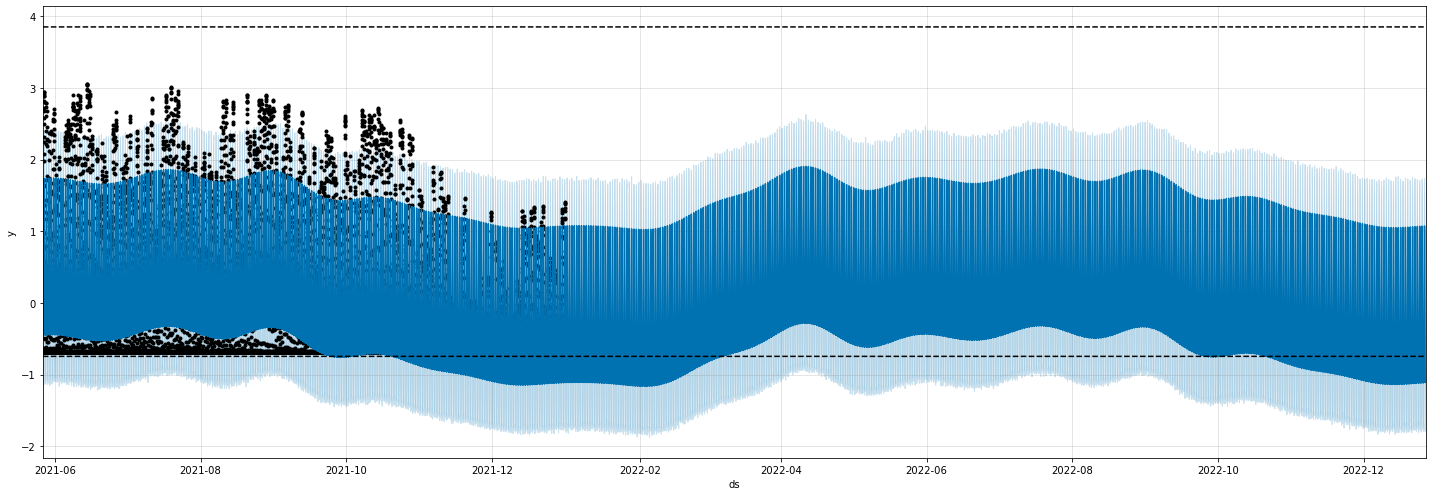

In [9]:
backtrack = (1 * 12 * 30 * 24) * 2
backtrack = int(backtrack)

fig = prophet1.plot(preds1[-backtrack - n_hours:], figsize=(20, 7))
plt.plot(data_st.ds[-backtrack:], data_st.y[-backtrack:], '--')
plt.xlim(data_st.ds.values[-backtrack], preds1.ds.values[-1] + np.timedelta64())
fig.show()

fig.savefig('prophet1_predictions.png')

In [10]:
def make_plot_block(preds, start, end, ax=None, xlabel='days'):

    # Truncate dataframes to only relevant portions
    actual = data_st.loc[(data_st.ds > start) & (data_st.ds < end), :].set_index('ds')
    forecast = preds.loc[(preds.ds > start) & (preds.ds < end), :].set_index('ds')

    actual.loc[:,'y'].plot(color='k', label='observations', ax=ax)
    forecast.loc[:,'yhat'].plot(color='steelblue', label='forecasts', ls='--', lw=3, ax=ax)
    ax.fill_between(forecast.index, forecast.loc[:,'yhat_lower'], forecast.loc[:,'yhat_upper'], color='steelblue', alpha=0.3)

    ax.grid(ls=':')
    ax.legend(fontsize=15)

    if xlabel == 'days':
        labels = [t.strftime('%b %d') for t in forecast.index]
    else:
        labels = [t.strftime("%b '") + t.strftime("%Y")[-2:] for t in forecast.index]
    ax.set_xticklabels(labels[::len(labels)//10], fontsize='large')

    [l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

    ax.set_ylabel('Energy Load', fontsize=15)
    ax.set_title(start + ' to ' + end, fontsize='xx-large')

def plot_seasons(preds, year):
    fig, ax = plt.subplots(4, 1, figsize=(20, 28))

    start = year + '-01-01'
    end = year + '-01-15'
    make_plot_block(preds, start, end, ax=ax[0], xlabel='days')

    start = year + '-04-01'
    end = year + '-04-15'
    make_plot_block(preds, start, end, ax=ax[1], xlabel='days')

    start = year + '-07-01'
    end = year + '-07-15'
    make_plot_block(preds, start, end, ax=ax[2], xlabel='days')

    start = year + '-10-01'
    end = year + '-10-15'
    make_plot_block(preds, start, end, ax=ax[3], xlabel='days')

    fig.subplots_adjust(hspace=0.35)
    return fig

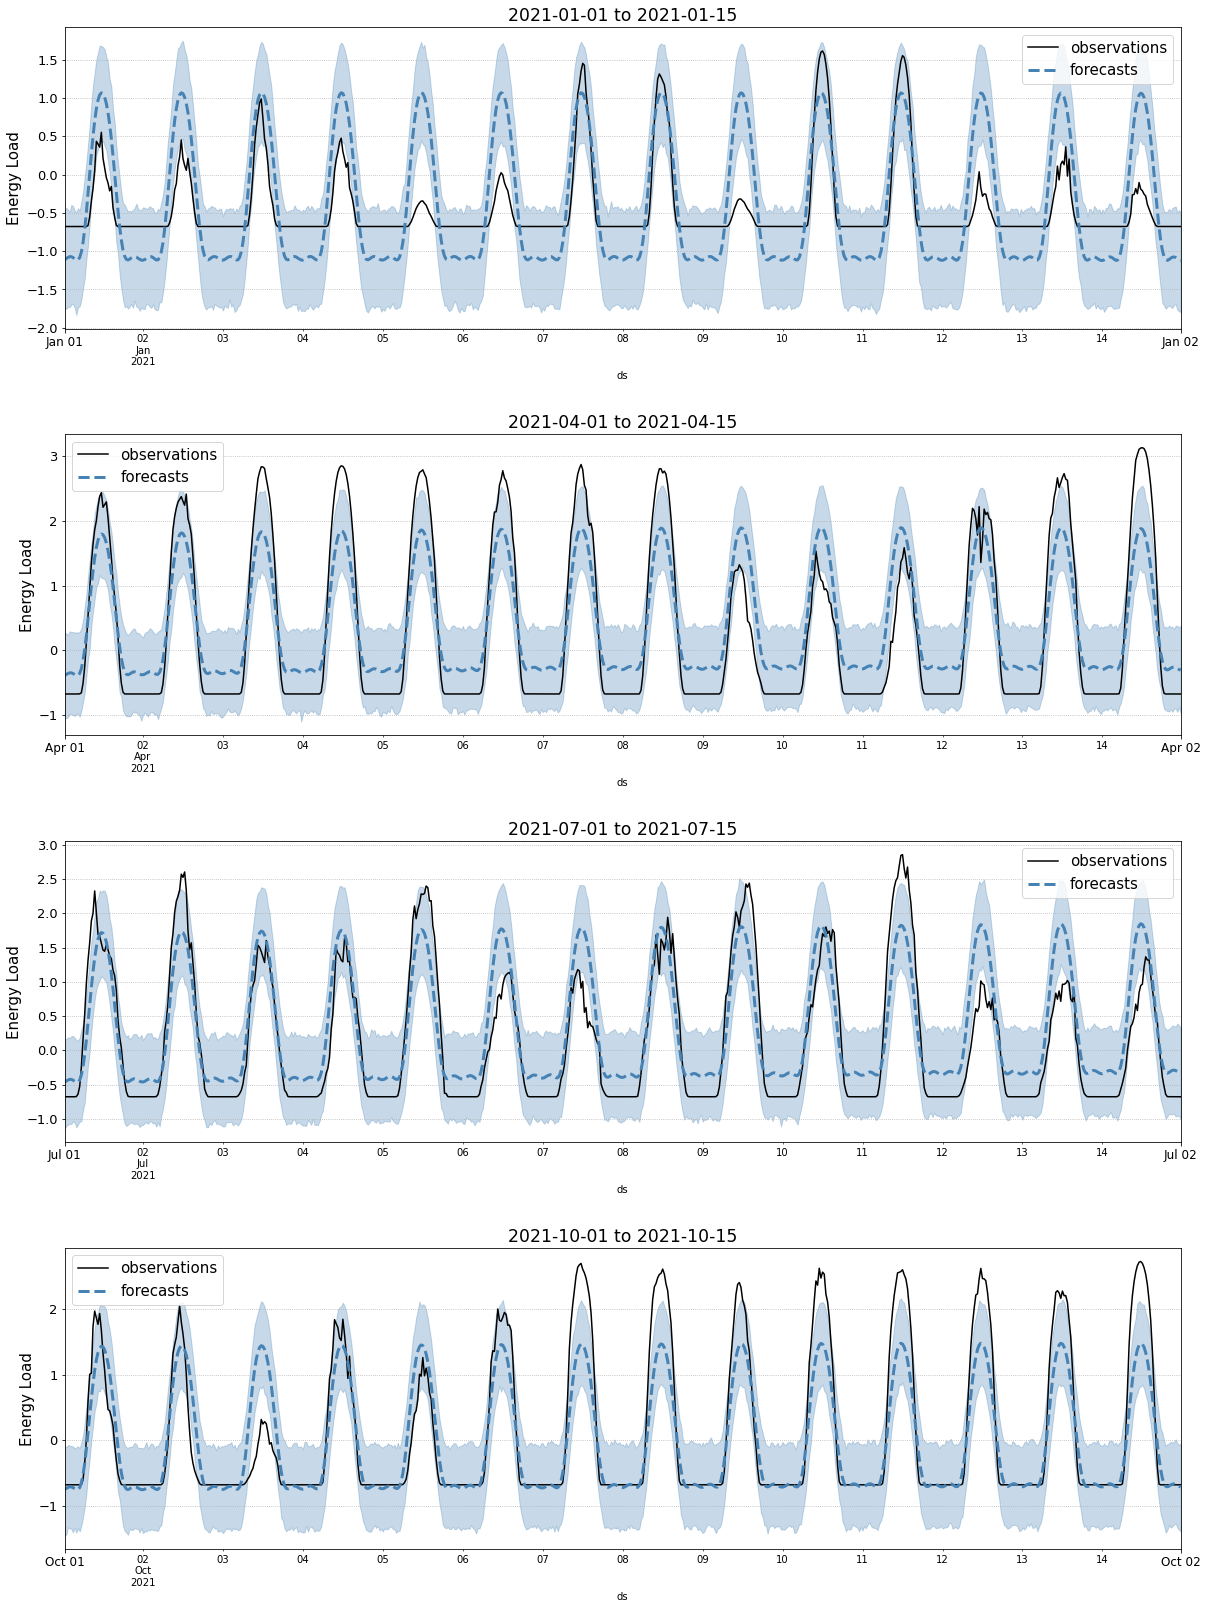

In [11]:
fig = plot_seasons(preds1, '2021')
fig.savefig('season_preds1.png')

### Examine the seasonality component of the model

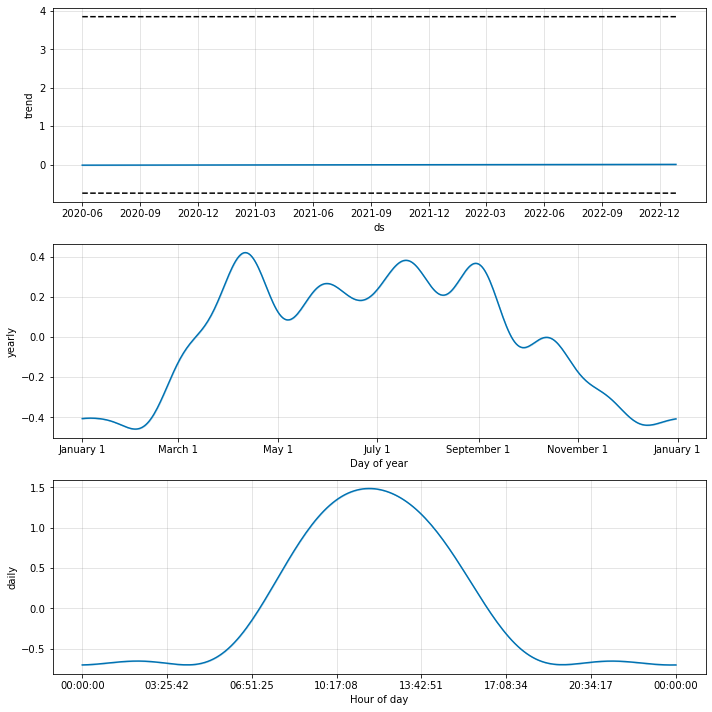

In [12]:
fig = prophet1.plot_components(preds1, figsize=(10, 10))
fig.savefig('prophet1_components.png')
fig.show()

### Model Validation

In [13]:
def mape(y_pred, y_true):
    ''' Mean average percent error statistic '''
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs(y_pred - y_true) / np.abs(y_true))

def unstandardize(y):
    return y * data.y.std() + data.y.mean()

In [14]:
result1_cv = diagnostics.cross_validation(prophet1, horizon="90 days")
result1_cv.to_csv('result1_cv.csv')

# Unstandardize the results
result1_cv_adj = result1_cv.copy()
result1_cv_adj[['yhat', 'yhat_lower', 'yhat_upper', 'y']] *= data.y.std()
result1_cv_adj[['yhat', 'yhat_lower', 'yhat_upper', 'y']] += data.y.mean()
#check out forecast
result1_cv_adj.to_csv('result1_cv_adj.csv')

INFO:prophet:Making 3 forecasts with cutoffs between 2021-07-04 22:30:00 and 2021-10-02 22:30:00


  0%|          | 0/3 [00:00<?, ?it/s]

In [15]:
for col in ['yhat', 'yhat_lower', 'yhat_upper', 'y']:
    result1_cv_adj[col].clip(lower=0.0)

In [16]:
result1_day = result1_cv_adj.groupby(by=[result1_cv_adj.ds.dt.day,
                                         result1_cv_adj.ds.dt.month,
                                         result1_cv_adj.ds.dt.year]).sum()
result1_month = result1_cv_adj.groupby(by=[result1_cv_adj.ds.dt.month,
                                           result1_cv_adj.ds.dt.year]).sum()
result1_ag = result1_cv_adj.groupby('cutoff').sum()

print("Monthly mean average percent error: {:.2%}".format(mape(result1_month.yhat, result1_month.y)))
print("3-month mean average percent error: {:.2%}".format(mape(result1_ag.yhat, result1_ag.y)))

Monthly mean average percent error: 22.30%
3-month mean average percent error: 5.21%


In [17]:
result1_cv_adj[['ds', 'yhat']]

ds          yhat
0     2021-07-04 23:00:00  6.558113e+05
1     2021-07-04 23:30:00  6.329250e+05
2     2021-07-05 00:00:00  6.284197e+05
3     2021-07-05 00:30:00  6.442354e+05
4     2021-07-05 01:00:00  6.743493e+05
...                   ...           ...
12931 2021-12-31 20:30:00 -1.092068e+06
12932 2021-12-31 21:00:00 -1.057642e+06
12933 2021-12-31 21:30:00 -1.044057e+06
12934 2021-12-31 22:00:00 -1.055004e+06
12935 2021-12-31 22:30:00 -1.083718e+06

[12936 rows x 2 columns]

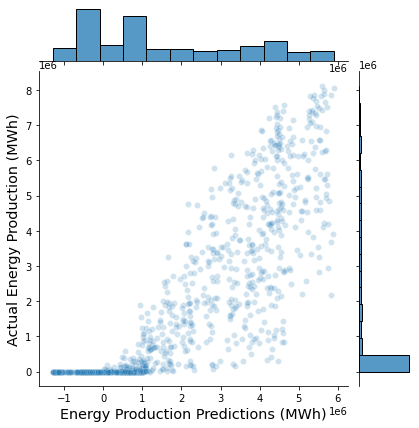

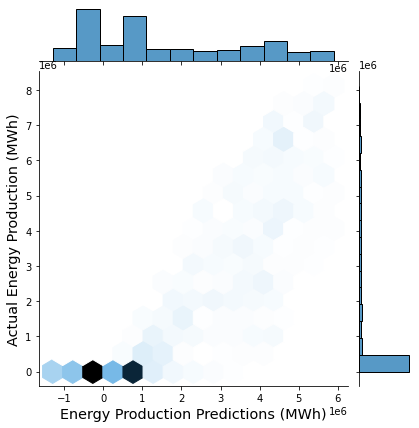

In [18]:
step = 10
grid = sns.jointplot(result1_cv_adj.yhat[::step], result1_cv_adj.y[::step], alpha=0.2)
grid.set_axis_labels('Energy Production Predictions (MWh)', 'Actual Energy Production (MWh)', fontsize='x-large')
grid.savefig('joint_scatter1.png')

grid = sns.jointplot(result1_cv_adj.yhat[::step], result1_cv_adj.y[::step], kind='hex')
grid.set_axis_labels('Energy Production Predictions (MWh)', 'Actual Energy Production (MWh)', fontsize='x-large')
grid.savefig('joint_hex1.png')

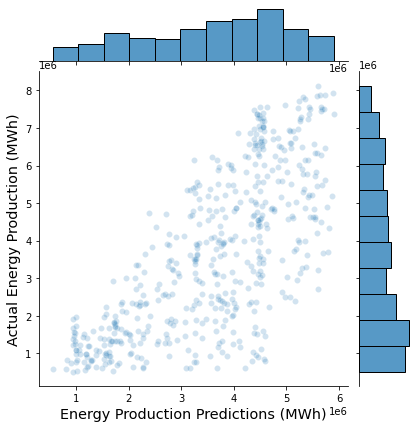

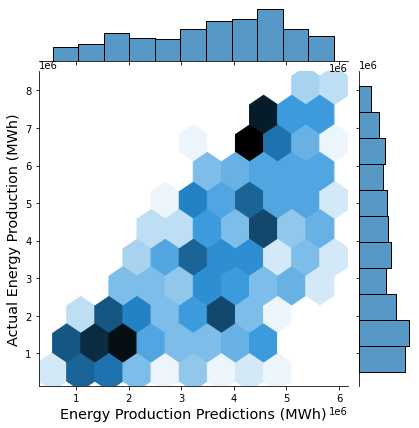

In [19]:
# remove all records where yhat is 0
result1_cv_adj = result1_cv_adj[result1_cv_adj.yhat > 0.5e6]
result1_cv_adj = result1_cv_adj[result1_cv_adj.y > 0.5e6]
step = 10
grid = sns.jointplot(result1_cv_adj.yhat[::step], result1_cv_adj.y[::step], alpha=0.2)
grid.set_axis_labels('Energy Production Predictions (MWh)', 'Actual Energy Production (MWh)', fontsize='x-large')
grid.savefig('joint_scatter1.png')

grid = sns.jointplot(result1_cv_adj.yhat[::step], result1_cv_adj.y[::step], kind='hex')
grid.set_axis_labels('Energy Production Predictions (MWh)', 'Actual Energy Production (MWh)', fontsize='x-large')
grid.savefig('joint_hex1.png')

In [20]:
def plot_residuals(errs, fig=None, ax=None, display=True):
    if not fig:
        fig, ax = plt.subplots(figsize=(7, 7))
    sns.distplot(errs, bins=50, ax=ax)
    ax.set_title('Histogram of Prediction Residuals (Test Set)', fontsize='xx-large')
    plt.axvline(errs.median(), color='k', label='median')
    ax.set_xlabel('Error (Wh)', fontsize='xx-large')
    ax.set_yticks([])

    if display:
        ax.text(0.05, 0.9, "Median = {:+4.2f} Wh".
                format((errs).median()),
                fontsize=14, transform=ax.transAxes)
    return fig

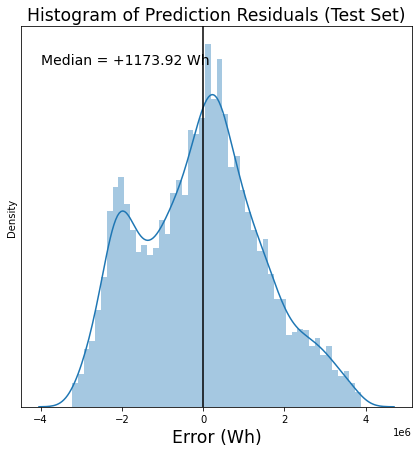

In [21]:
errs1 = result1_cv_adj.yhat - result1_cv_adj.y      # Units are now Wh, not standardized
fig = plot_residuals(errs1)
fig.savefig('residuals1_hist.png')
fig.show()

In [22]:
print('The median error was {0:.2%} of the mean energy demand.'.format(errs1.median() / result1_cv_adj.y.mean()))

The median error was 0.03% of the mean energy demand.


Text(0.05, 0.1, 'Min Error = -3227493.79 Wh')

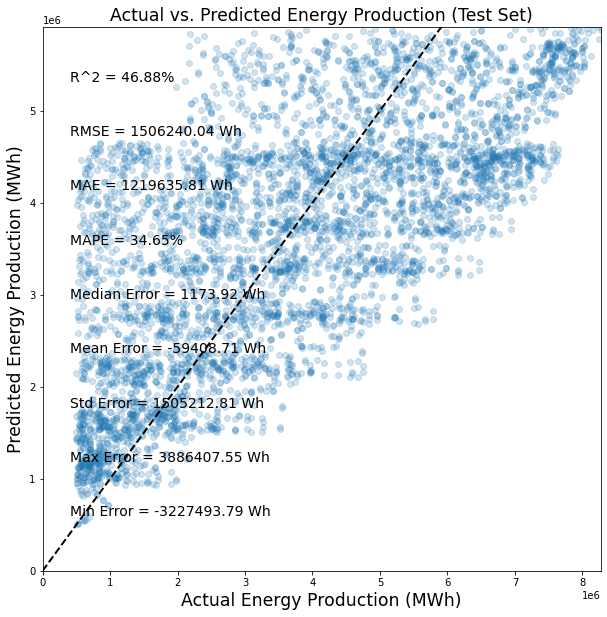

In [24]:
# Show the error between the actual and predicted values
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.scatter(result1_cv_adj.y, result1_cv_adj.yhat, alpha=0.2)
ax.set_title('Actual vs. Predicted Energy Production (Test Set)', fontsize='xx-large')
ax.set_xlabel('Actual Energy Production (MWh)', fontsize='xx-large')
ax.set_ylabel('Predicted Energy Production (MWh)', fontsize='xx-large')
ax.set_xlim(0, result1_cv_adj.y.max())
ax.set_ylim(0, result1_cv_adj.yhat.max())
ax.plot([0, result1_cv_adj.y.max()], [0, result1_cv_adj.y.max()], 'k--', lw=2)
ax.text(0.05, 0.9, "R^2 = {:.2%}".format(r2_score(result1_cv_adj.y, result1_cv_adj.yhat)),
        fontsize=14, transform=ax.transAxes)
ax.text(0.05, 0.8, "RMSE = {:.2f} Wh".format(np.sqrt(mean_squared_error(result1_cv_adj.y, result1_cv_adj.yhat))),
        fontsize=14, transform=ax.transAxes)
ax.text(0.05, 0.7, "MAE = {:.2f} Wh".format(mean_absolute_error(result1_cv_adj.y, result1_cv_adj.yhat)),
        fontsize=14, transform=ax.transAxes)
ax.text(0.05, 0.6, "MAPE = {:.2%}".format(mape(result1_cv_adj.y, result1_cv_adj.yhat)),
        fontsize=14, transform=ax.transAxes)
ax.text(0.05, 0.5, "Median Error = {:.2f} Wh".format(errs1.median()),
        fontsize=14, transform=ax.transAxes)
ax.text(0.05, 0.4, "Mean Error = {:.2f} Wh".format(errs1.mean()),
        fontsize=14, transform=ax.transAxes)
ax.text(0.05, 0.3, "Std Error = {:.2f} Wh".format(errs1.std()),
        fontsize=14, transform=ax.transAxes)
ax.text(0.05, 0.2, "Max Error = {:.2f} Wh".format(errs1.max()),
        fontsize=14, transform=ax.transAxes)
ax.text(0.05, 0.1, "Min Error = {:.2f} Wh".format(errs1.min()),
        fontsize=14, transform=ax.transAxes)
